In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import featuretools as ft
%matplotlib inline

In [2]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')
submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
submission['is_turkey'].unique()

array([0])

In [4]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 5 columns):
audio_embedding                    1195 non-null object
end_time_seconds_youtube_clip      1195 non-null int64
is_turkey                          1195 non-null int64
start_time_seconds_youtube_clip    1195 non-null int64
vid_id                             1195 non-null object
dtypes: int64(3), object(2)
memory usage: 46.8+ KB


In [5]:

tgt = train[['is_turkey','vid_id']].copy()
train['set']='train'
test['set']='test'
train.drop(columns='is_turkey',axis=1,inplace=True)
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 5 columns):
audio_embedding                    1196 non-null object
end_time_seconds_youtube_clip      1196 non-null int64
start_time_seconds_youtube_clip    1196 non-null int64
vid_id                             1196 non-null object
set                                1196 non-null object
dtypes: int64(2), object(3)
memory usage: 46.8+ KB


In [6]:
data = train.append(test, ignore_index=True, sort=False)
data.tail()

,audio_embedding,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip,vid_id,set
2386,"[[153, 26, 118, 69, 255, 87, 153, 59, 125, 204...",11,1,lQOQR6HCGyE,test
2387,"[[159, 8, 163, 128, 172, 64, 36, 56, 110, 236,...",40,30,CqhPMjumTOA,test
2388,"[[78, 56, 132, 20, 92, 120, 6, 133, 191, 156, ...",40,30,Ccn2LQJc2MI,test
2389,"[[81, 115, 208, 104, 236, 91, 95, 71, 161, 152...",40,30,f6OhmrIdB-g,test
2390,"[[164, 21, 189, 141, 198, 32, 151, 69, 129, 16...",20,10,vCxGJelmAeg,test


In [7]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2391 entries, 0 to 2390
Data columns (total 5 columns):
audio_embedding                    2391 non-null object
end_time_seconds_youtube_clip      2391 non-null int64
start_time_seconds_youtube_clip    2391 non-null int64
vid_id                             2391 non-null object
set                                2391 non-null object
dtypes: int64(2), object(3)
memory usage: 93.5+ KB


In [8]:
data.head()

,audio_embedding,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip,vid_id,set
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",70,60,kDCk3hLIVXo,train
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",40,30,DPcGzqHoo7Y,train
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",240,230,7yM63MTHh5k,train
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",520,510,luG3RmUAxxM,train
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",10,0,PIm3cjxTpOk,train


In [9]:
data['vid_id'].is_unique

True

In [10]:
data.index = data['vid_id']
data.drop(columns='vid_id',axis=1, inplace=True)

data.head()

,audio_embedding,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip,set
vid_id,,,,
kDCk3hLIVXo,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",70,60,train
DPcGzqHoo7Y,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",40,30,train
7yM63MTHh5k,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",240,230,train
luG3RmUAxxM,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",520,510,train
PIm3cjxTpOk,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",10,0,train


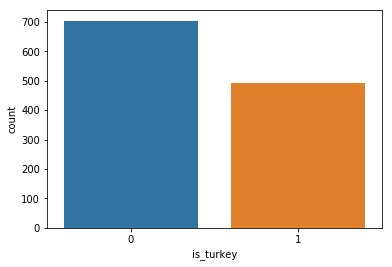

In [11]:
sns.countplot(x='is_turkey',data=tgt)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer

In [13]:
# got this function idea from refering below kernel:
#https://www.kaggle.com/teemingyi/turkey-competition
#thanks !!
def auto_embed_to_cols(data,i):
    df=pd.DataFrame(data['audio_embedding'].loc[i])
    df['vid_id']=i
    return df

In [14]:
auto_embeds =[]
for i in data.index:
    auto_embeds.append(auto_embed_to_cols(data,i))
    
auto_embed_values = pd.concat(auto_embeds)
auto_embed_values.shape

(23634, 129)

In [15]:
auto_embed_values.columns=['feature_'+str(x) for x in auto_embed_values.columns[:128]] + ['vid_id']
auto_embed_values.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,vid_id
0,172,34,216,110,208,46,95,66,161,125,83,39,106,146,90,144,109,111,194,58,24,228,81,128,18,94,197,161,56,0,85,97,206,74,165,126,95,121,132,105,...,0,156,215,255,255,68,255,148,0,247,206,91,18,177,191,54,116,79,92,36,12,153,29,96,170,26,255,162,255,0,0,1,170,0,8,255,129,4,255,kDCk3hLIVXo
1,171,39,199,121,238,62,59,61,170,146,96,76,121,139,76,102,146,142,159,64,0,252,119,134,93,90,176,215,120,42,134,160,159,87,86,190,111,89,61,47,...,0,122,186,246,109,111,255,101,31,93,115,112,0,51,201,138,227,93,190,142,119,255,157,91,252,89,237,53,98,0,70,0,237,0,49,255,126,188,255,kDCk3hLIVXo
2,169,33,200,97,210,22,73,51,169,129,101,91,110,158,72,116,117,113,131,68,0,255,80,187,57,100,229,138,130,26,110,125,188,62,55,138,118,93,109,69,...,0,183,255,253,187,137,255,178,0,255,252,182,0,46,49,154,243,89,160,65,105,153,96,94,208,147,204,129,48,0,48,106,207,0,39,234,205,33,255,kDCk3hLIVXo
3,180,39,218,118,213,73,80,43,160,147,97,45,92,145,109,84,152,174,137,94,58,188,52,148,28,119,155,222,79,97,159,189,66,114,126,183,146,70,95,151,...,0,194,232,248,110,124,255,62,0,111,90,159,94,155,157,35,255,13,228,199,245,56,166,192,239,186,205,46,194,19,117,35,137,0,58,255,103,153,255,kDCk3hLIVXo
4,166,31,204,134,211,59,62,73,187,167,71,69,114,171,75,110,88,113,147,103,19,238,111,141,9,107,204,177,107,0,89,61,187,109,139,103,169,91,3,129,...,0,99,241,223,212,122,255,148,0,148,158,62,5,217,107,145,216,134,55,63,71,255,71,127,164,37,213,173,215,0,0,0,219,0,152,255,58,177,255,kDCk3hLIVXo


In [16]:
data = pd.merge(data,auto_embed_values, left_index=True, right_on='vid_id',how='inner')
data.drop(columns='audio_embedding',axis=1,inplace=True)
data.shape

(23634, 132)

In [17]:
data[data['set']=='test'].shape

(11839, 132)

In [18]:
#A nice way for identifying correlated features by Will Koehrsen in,
#https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
data_corr = data.corr()
upper = data_corr.where(np.triu(np.ones(data_corr.shape),k=1).astype(np.bool))
to_drop = [col for col in data_corr.columns if any(abs(upper[col])>0.9)]
print(to_drop)

['start_time_seconds_youtube_clip']


In [19]:
data_updated=data.copy()
data_updated['duration'] = data['start_time_seconds_youtube_clip']-data['end_time_seconds_youtube_clip']
data_updated.drop(columns='start_time_seconds_youtube_clip',axis=1,inplace=True)

In [20]:
data_updated[data_updated['set']=='test'].shape

(11839, 132)

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [22]:
scorer = make_scorer(roc_auc_score, greater_is_better=True)
final_train = data_updated[data_updated['set']=='train'].merge(tgt, how='inner', on='vid_id')
final_test = data_updated[data_updated['set']=='test'].merge(submission, how='inner', on='vid_id')
y_train = final_train[['is_turkey']]
X_train = final_train.drop(columns=['vid_id','set','is_turkey'],axis=1)
y_test = final_test[['is_turkey']]
X_test = final_test.drop(columns=['vid_id','set','is_turkey'],axis=1)
sc = StandardScaler()
X_train_stdsc = sc.fit_transform(X_train)
X_test_stdsc = sc.transform(X_test)
X_train_stdsc

array([[-0.16658737,  0.74209218, -0.22921266, ..., -1.11164483,
         0.47353402, -0.08048369],
       [-0.16658737,  0.71854469, -0.13260024, ...,  1.03511338,
         0.47353402, -0.08048369],
       [-0.16658737,  0.67144972, -0.24853514, ..., -0.77329707,
         0.47353402, -0.08048369],
       ...,
       [-0.44422252,  0.57725978, -0.09395527, ...,  1.81681338,
         0.47353402, -0.08048369],
       [-0.44422252,  0.55371229, -0.19056769, ...,  0.96511039,
         0.47353402, -0.08048369],
       [-0.44422252,  0.6949972 , -0.0553103 , ...,  1.81681338,
         0.47353402, -0.08048369]])

In [23]:
model_results = pd.DataFrame(columns=['model','cv_mean','cv_std'])
def model_cv(model, X_train, y_train, name, nfolds=10, model_results=None):
    cv_scores = cross_val_score(estimator=model, 
                                X=X_train, y=y_train,
                                scoring=scorer, n_jobs=-1,
                                cv=nfolds
                               )
    print(f'{nfolds} CV score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    if model_results is not None:
        model_results = model_results.append({'model':name,'cv_mean':cv_scores.mean(),'cv_std':cv_scores.std()},
                                             ignore_index=True)
    return model_results

In [24]:
#Baseline Logreg score
model_results = model_cv(model = LogisticRegression(),
                         X_train=X_train,
                         y_train = y_train,
                         name = 'LogReg',
                         nfolds=10,
                         model_results=model_results                        
                        )

10 CV score: 0.8854 with std: 0.0205


In [25]:
def gridsearch(model, param_grid, X_train, y_train, nfolds):
    gs = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, scoring=scorer, cv=nfolds, iid=True
                      ,verbose=10)
    gs.fit(X_train,y_train)
    #scores = cross_val_score(estimator=gs, X=X_train_stdsc, y=y_train, cv=nfolds, scoring=scorer,n_jobs=-1)

    #print(f'10 fold CV score: {round(scores.mean(), 5)} with std: {round(scores.std(), 5)}')
    print(f'best score: {gs.best_score_}\n Best Params: {gs.best_params_}')
    return gs.best_score_, gs.best_params_

In [26]:
submission['is_turkey'].unique()

array([0])

In [27]:
param_grid = [{'penalty':['l1','l2'],
               'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100] ,
               'class_weight':[None, 'balanced']
              }]
best_score_logreg, best_param_logreg = gridsearch(model = LogisticRegression(solver='liblinear',multi_class='ovr', n_jobs=-1)
                  , param_grid=param_grid, X_train=X_train_stdsc, y_train = y_train.values.ravel() , nfolds=10)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1703s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0182s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:   23.9s
[Parallel(n_jo

best score: 0.8902861771163731
 Best Params: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}


In [28]:
model_results = model_cv(model = LogisticRegression(**best_param_logreg),
                         X_train=X_train_stdsc,
                         y_train = y_train,
                         name = 'LogReg_stdsc_gs',
                         nfolds=10,
                         model_results=model_results                        
                        )

10 CV score: 0.89028 with std: 0.01639


In [29]:
#SVM
from sklearn.svm import SVC
import time
start= time.time()
model_results = model_cv(model = SVC(),
                         X_train=X_train_stdsc,
                         y_train = y_train,
                         name = 'SVC',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.88838 with std: 0.01539
Total TIme: 37.97131657600403


In [30]:
#reg_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
#param_grid=[{'C':reg_range,
#             'kernel':['linear']
##             'gamma':range(1,20,5)
#            }]
#
#best_score_svc, best_param_svc = gridsearch(model = SVC()
#                  , param_grid=param_grid, X_train=X_train_stdsc, y_train = y_train.values.ravel() , nfolds=2)

In [31]:
best_param_svc= {'C': 0.001, 'kernel': 'linear'}
start= time.time()
model_results = model_cv(model = SVC(**best_param_svc),
                         X_train=X_train_stdsc,
                         y_train = y_train,
                         name = 'SVC_gs',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.88322 with std: 0.02247
Total TIme: 30.201937913894653


In [32]:
from sklearn.ensemble import RandomForestClassifier
start= time.time()
model_results = model_cv(model = RandomForestClassifier(n_estimators=100),
                         X_train=X_train_stdsc,
                         y_train = y_train,
                         name = 'RFC',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.88137 with std: 0.02049
Total TIme: 25.58137083053589


In [33]:
#reg_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
#param_grid=[{'n_estimators':range(50,500,50),
#             'max_depth':range(2,150,10),
#             'min_samples_split':[2,5,10],
#             'min_samples_leaf':[1,2,4],
#             'bootstrap':[True,False]
#            }]
#
#best_score_rfc, best_param_rfc = gridsearch(model = RandomForestClassifier()
#                  , param_grid=param_grid, X_train=X_train_stdsc, y_train = y_train.values.ravel() , nfolds=2)

In [34]:
start= time.time()
model_results = model_cv(model = RandomForestClassifier(n_estimators=400, bootstrap=False,
                                                        max_depth=132,min_samples_leaf=1,
                                                        min_samples_split=5
                                                       ),
                         X_train=X_train_stdsc,
                         y_train = y_train,
                         name = 'RFC_gs',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.88378 with std: 0.02105
Total TIme: 158.82638144493103


In [35]:
from sklearn.neighbors import KNeighborsClassifier
for i in [2,5,10,20]:
    print(f'KNN neighbors: {i}')
    start= time.time()
    model_results = model_cv(model = KNeighborsClassifier(n_neighbors=i),
                             X_train=X_train_stdsc,
                             y_train = y_train,
                             name = f'KNN-{i}',
                             nfolds=10,
                             model_results=model_results                        
                            )
    end=time.time()
    print(f'Total TIme for KNN-{i}: {end-start}')
    

KNN neighbors: 2
10 CV score: 0.83161 with std: 0.02049
Total TIme for KNN-2: 21.079197883605957
KNN neighbors: 5
10 CV score: 0.87406 with std: 0.01711
Total TIme for KNN-5: 21.232542991638184
KNN neighbors: 10
10 CV score: 0.87153 with std: 0.02033
Total TIme for KNN-10: 21.449723482131958
KNN neighbors: 20
10 CV score: 0.87394 with std: 0.01884
Total TIme for KNN-20: 21.23302149772644


In [36]:
from lightgbm import LGBMClassifier
start= time.time()
model_results = model_cv(model = LGBMClassifier(),
                         X_train=X_train_stdsc,
                         y_train = y_train,
                         name = 'LGBM',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.88208 with std: 0.01599
Total TIme: 18.88165259361267


Text(0, 0.5, 'Mean F1 Score (with error bar)')

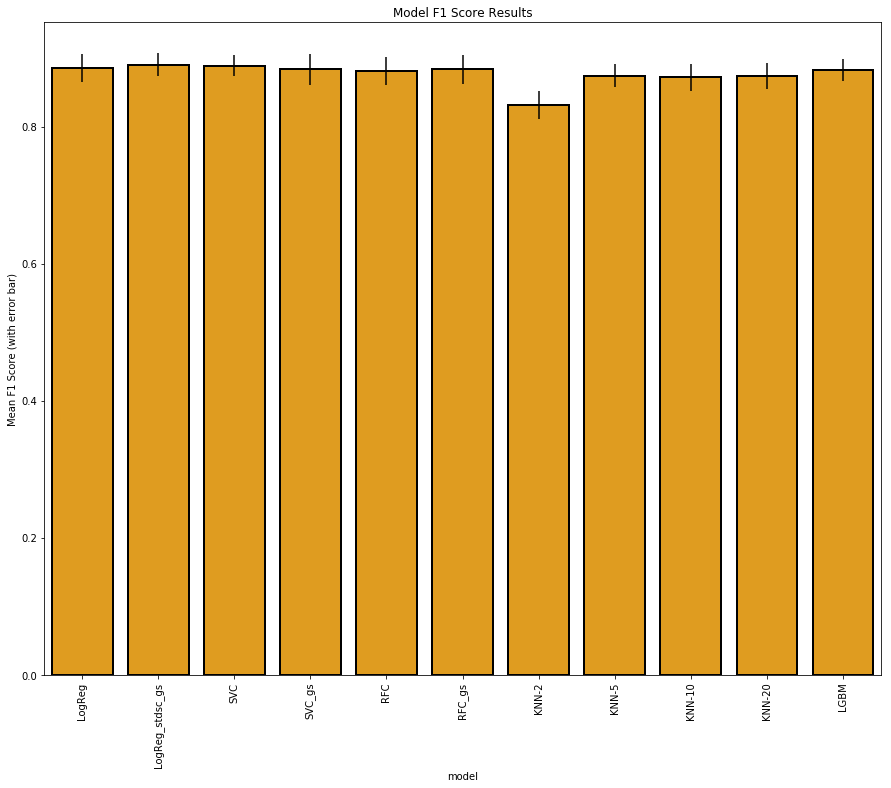

In [37]:
plt.figure(figsize=(15,12))
sns.barplot(data=model_results, x='model',y='cv_mean',yerr=list(model_results['cv_std']),color='orange',edgecolor='k',linewidth=2)
plt.xticks(rotation=90)
plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')

In [38]:
#scorer = make_scorer(roc_auc_score, greater_is_better=True)
final_train = data_updated[data_updated['set']=='train'].merge(tgt, how='inner', on='vid_id')
final_test = data_updated[data_updated['set']=='test'].merge(submission, how='inner', on='vid_id')
#y_train = final_train[['is_turkey']]
X_train2 = final_train.drop(columns=['set'],axis=1)
#y_test = final_test[['is_turkey']]
X_test2 = final_test.drop(columns=['set'],axis=1)
#sc = StandardScaler()
#X_train_stdsc = sc.fit_transform(X_train)
#X_test_stdsc = sc.transform(X_test)
#X_train_stdsc

In [39]:
#Adding additional information from data
#https://www.kaggle.com/frtgnn/yam-potatoes-thanksgiving-2018
#Thanks!

X_train2_columns = X_train2.columns
X_test2_columns  = X_test2.columns

X_train2['all_feature_mean'] = X_train2[X_train2_columns[4:131]].mean(axis=1)
X_test2['all_feature_mean']  = X_test2[X_test2_columns[3:130]].mean(axis=1)

X_train2['all_feature_median'] = X_train2[X_train2_columns[4:131]].median(axis=1)
X_test2['all_feature_median']  = X_test2[X_test2_columns[3:130]].median(axis=1)

X_train2['all_feature_min'] = X_train2[X_train2_columns[4:131]].min(axis=1)
X_test2['all_feature_min']  = X_test2[X_test2_columns[3:130]].min(axis=1)

X_train2['all_feature_max'] = X_train2[X_train2_columns[4:131]].max(axis=1)
X_test2['all_feature_max']  = X_test2[X_test2_columns[3:130]].max(axis=1)

X_train2['all_feature_std'] = X_train2[X_train2_columns[4:131]].std(axis=1)
X_test2['all_feature_std']  = X_test2[X_test2_columns[3:130]].std(axis=1)

In [40]:
X_train2_concat = X_train2.groupby('vid_id').mean()
y_train_concat = X_train2_concat['is_turkey']
X_train2_concat.drop(['is_turkey'],axis=1,inplace=True)

X_test2_concat = X_test2.groupby('vid_id').mean()
y_test = X_test2_concat['is_turkey']
X_test2_concat.drop(['is_turkey'],axis=1,inplace=True)

In [41]:
sc = StandardScaler()
X_train2_concat_stdsc = sc.fit_transform(X_train2_concat)
X_test2_concat_stdsc = sc.transform(X_test2_concat)
X_train2_concat_stdsc

array([[-0.71503497, -0.35027356,  2.34576809, ..., -0.11576637,
         0.13217716, -0.17959525],
       [ 1.60610353, -2.50978043,  1.56972125, ..., -0.11576637,
         0.13217716,  1.72416946],
       [ 1.23472137, -1.34465114,  0.81844186, ..., -0.11576637,
         0.13217716, -1.09741339],
       ...,
       [-0.43649835,  0.87260999, -0.39722726, ..., -0.11576637,
         0.13217716,  0.40608367],
       [-0.06511619,  0.32017799, -0.66554132, ..., -0.11576637,
         0.13217716, -0.01236945],
       [-0.67789675, -0.35278461,  2.02172726, ..., -0.11576637,
         0.13217716,  0.45334572]])

In [42]:
model_results = model_cv(model = LogisticRegression(),
                         X_train=X_train2_concat,
                         y_train = y_train_concat,
                         name = 'LogReg_new_data',
                         nfolds=10,
                         model_results=model_results                        
                        )

10 CV score: 0.92716 with std: 0.01833


In [43]:
param_grid = [{'penalty':['l1'],
               'solver':['liblinear','saga'],
               'C':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100] ,
               'class_weight':[None, 'balanced']},
              {'solver':['newton-cg', 'lbfgs', 'sag','saga'],
               'penalty':['l2','none'],
               'C':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100] ,
               'class_weight':[None, 'balanced']                 
              }]
best_score_logreg, best_param_logreg = gridsearch(model = LogisticRegression(multi_class='ovr', n_jobs=-1,max_iter=100)
                  , param_grid=param_grid, X_train=X_train2_concat, y_train = y_train_concat.values.ravel() , nfolds=10)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0359s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1573s.) Setting batch_size=5.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (7.5819s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Batch computation too slow (14.2685s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 251 

best score: 0.9569708892927197
 Best Params: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [44]:
model_results = model_cv(model = LogisticRegression(**best_param_logreg),
                         X_train=X_train2_concat,
                         y_train = y_train_concat,
                         name = 'LogReg_new_data_gs',
                         nfolds=10,
                         model_results=model_results                        
                        )

10 CV score: 0.95625 with std: 0.01822


In [45]:
import time
from sklearn.svm import SVC
start= time.time()
model_results = model_cv(model = SVC(),
                         X_train=X_train2_concat,
                         y_train = y_train_concat,
                         name = 'SVC_new_data',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.5 with std: 0.0
Total TIme: 1.1166093349456787


In [46]:
#reg_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
#param_grid=[{'C':reg_range,
#             'kernel':['poly'],
#             'gamma':range(1,5,1),
#             'degree':range(1,5,1)
#            }]
#
#best_score_svc, best_param_svc = gridsearch(model = SVC()
#                  , param_grid=param_grid, X_train=X_train2_concat, y_train = y_train_concat.values.ravel() , nfolds=2)

In [47]:
best_param_svc= {'C': 0.0001, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}
start= time.time()
model_results = model_cv(model = SVC(**best_param_svc),
                         X_train=X_train2_concat,
                         y_train = y_train_concat,
                         name = 'SVC_new_data_gs',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.94143 with std: 0.01764
Total TIme: 0.3207228183746338


In [48]:
from sklearn.ensemble import RandomForestClassifier
start= time.time()
model_results = model_cv(model = RandomForestClassifier(n_estimators=100),
                         X_train=X_train2_concat,
                         y_train = y_train_concat,
                         name = 'RFC_new_data',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.93249 with std: 0.02818
Total TIme: 2.575547456741333


In [49]:
#reg_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 
#param_grid=[{'n_estimators':range(400,600,50),
#             'max_depth':range(120,150,10),
#             'min_samples_split':[2,5,10],
#             'min_samples_leaf':[1,2,3],
#             'bootstrap':[True,False]
#            }]

#best_score_rfc, best_param_rfc = gridsearch(model = RandomForestClassifier()
#                  , param_grid=param_grid, X_train=X_train2_concat, y_train = y_train_concat.values.ravel() , nfolds=5)

In [50]:
best_param_rfc= {'bootstrap': True, 'max_depth': 62, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
start= time.time()
model_results = model_cv(model = RandomForestClassifier(**best_param_rfc),
                         X_train=X_train2_concat,
                         y_train = y_train_concat,
                         name = 'RFC_new_data_gs',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.93621 with std: 0.02756
Total TIme: 3.8079607486724854


In [51]:
from sklearn.neighbors import KNeighborsClassifier
for i in [2,5,10,20]:
    print(f'KNN neighbors: {i}')
    start= time.time()
    model_results = model_cv(model = KNeighborsClassifier(n_neighbors=i),
                             X_train=X_train2_concat,
                             y_train = y_train_concat,
                             name = f'KNN_new_data-{i}',
                             nfolds=10,
                             model_results=model_results                        
                            )
    end=time.time()
    print(f'Total TIme for KNN-{i}: {end-start}')

KNN neighbors: 2
10 CV score: 0.88238 with std: 0.03146
Total TIme for KNN-2: 0.29679322242736816
KNN neighbors: 5
10 CV score: 0.9205 with std: 0.02189
Total TIme for KNN-5: 0.2882823944091797
KNN neighbors: 10
10 CV score: 0.91743 with std: 0.01686
Total TIme for KNN-10: 0.2967355251312256
KNN neighbors: 20
10 CV score: 0.91213 with std: 0.0175
Total TIme for KNN-20: 0.29691386222839355


In [52]:
from lightgbm import LGBMClassifier
start= time.time()
model_results = model_cv(model = LGBMClassifier(),
                         X_train=X_train2_concat,
                         y_train = y_train_concat,
                         name = 'LGBM_new_data',
                         nfolds=10,
                         model_results=model_results                        
                        )
end=time.time()
print(f'Total TIme: {end-start}')

10 CV score: 0.94063 with std: 0.02158
Total TIme: 9.25490665435791


Text(0, 0.5, 'Mean ROC Score (with error bar)')

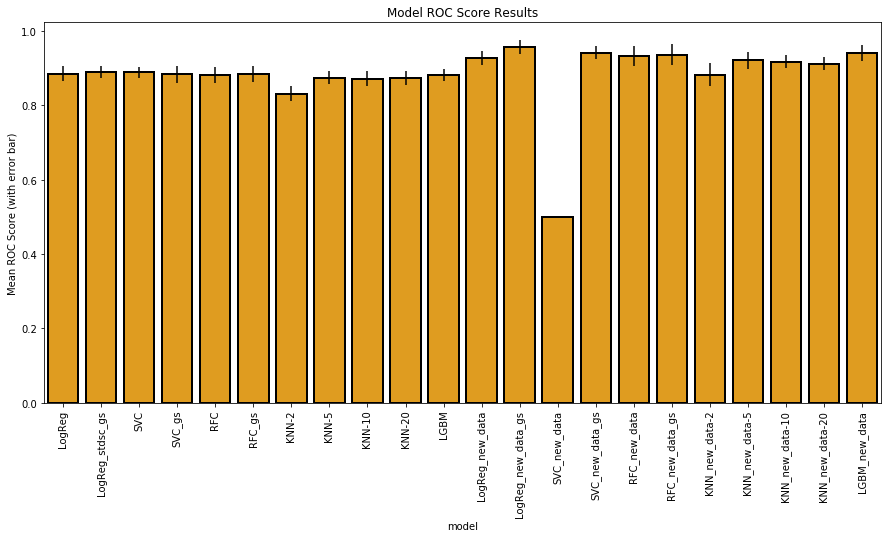

In [53]:
plt.figure(figsize=(15,7))
sns.barplot(data=model_results, x='model',y='cv_mean',yerr=list(model_results['cv_std']),color='orange',edgecolor='k',linewidth=2)
plt.xticks(rotation=90)
plt.title('Model ROC Score Results')
plt.ylabel('Mean ROC Score (with error bar)')

In [54]:
# Additional features have massive effect! This indicates initial data was not enough.
# Tuned Logreg leads with 0.95! Regularisation results in increase of 0.03!!
# Power of LGBM!!It reaches 0.94 without tuning.
# Need to re-tune RFC.
# SVC tuning indicates massive effect due to regularisation. Need to re-tune with multiple kernels and verify.

In [55]:
from IPython.display import display
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
def modelgbm(X_train, y_train, X_test, train_features, nfolds=5):
    model = lgb.LGBMClassifier( objective='binary', n_jobs=-1, n_estimators=10000)
    strkfold = StratifiedKFold(n_splits=nfolds,shuffle=True)
    predictions = pd.DataFrame()
    importances = np.zeros(len(train_features))
    tr = np.array(X_train)
    ts = np.array(X_test)
    tgt = np.array(y_train).reshape((-1))
    valid_scores=[]
    
    for i, (train_indices, tgt_indices) in enumerate(strkfold.split(tr,tgt)):
        
        fold_predictions = pd.DataFrame()
        
        X_tr = tr[train_indices]
        X_tgt = tr[tgt_indices]
        y_tr = tgt[train_indices]
        y_tgt = tgt[tgt_indices]
        
        model.fit(X=X_tr, y=y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr,y_tr), (X_tgt,y_tgt)],
                  eval_names=['train','valid'],
                  verbose=200
                 )
        
        valid_scores.append(model.best_score_['valid']['auc'])
        fold_probabilities = model.predict_proba(X_test)
        for j in range(2):
            fold_predictions[j] = fold_probabilities[:,j]
        fold_predictions['vid_id'] = X_test.index
        fold_predictions['fold'] = i+1
        predictions = predictions.append(fold_predictions)
        importances = model.feature_importances_/nfolds
        print(f'Fold {i+1}: Validation Score = {round(valid_scores[i],5)}, Estimators Trained = {model.best_iteration_}')
    
    feature_importances = pd.DataFrame({'feature':train_features, 'importance':importances})
    #if return_preds:
    #    predictions['Target'] = predictions[[0,1]].idxmax(axis=1)
    #    predictions['Probability_Confidence'] = predictions[[0,1]].max(axis=1)
    predictions['Target'] = predictions[[0,1]].idxmax(axis=1)
    predictions['Probability_Confidence'] = predictions[[0,1]].max(axis=1)
    predictions = predictions.groupby('vid_id',as_index=False).mean()
    submission = predictions[['vid_id','Target']].copy()
    submission.columns = ['vid_id','is_turkey']
    
    return valid_scores, predictions,submission

In [56]:
valid_scores, predictions,submission=modelgbm(X_train=X_train2_concat, y_train = y_train_concat, X_test=X_test2_concat, train_features=X_train2_concat.columns)


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[36]	train's binary_logloss: 0.0464105	train's auc: 1	valid's binary_logloss: 0.109838	valid's auc: 0.993696
Fold 1: Validation Score = 0.9937, Estimators Trained = 36
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[32]	train's binary_logloss: 0.0552056	train's auc: 1	valid's binary_logloss: 0.201634	valid's auc: 0.976118
Fold 2: Validation Score = 0.97612, Estimators Trained = 32
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	train's binary_logloss: 0.0628133	train's auc: 1	valid's binary_logloss: 0.142817	valid's auc: 0.990447
Fold 3: Validation Score = 0.99045, Estimators Trained = 31
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[35]	train's binary_logloss: 0.0449164	train's auc: 1	valid's binary_logloss: 0.188904	valid's auc: 0.

In [57]:
submission.to_csv('submission.csv', index=False)